# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Link / objectives

Energy star : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

Problématique de la ville de Seattle
Des relevés minutieux ont été effectués par vos agents en __2015 et en 2016__. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de __l’"ENERGY STAR Score"__ pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:

- __Réaliser une courte analyse exploratoire.__
- __Tester différents modèles de prédiction afin de répondre au mieux à la problématique.__\


Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Load and clean

## Load Data

In [76]:
df_2015=pd.read_csv('./data/2015-building-energy-benchmarking.csv')
df_2016=pd.read_csv('./data/2016-building-energy-benchmarking.csv')

Le fait d'avoir deux datasets est embetant -> je vais essayer de les concatener sans perdre de la data

## Columns analysis

Analyse des colonnes pour pouvoir concat les deux datasets

In [77]:
len(df_2015.columns)==len(df_2016.columns)

False

In [78]:
col_2015=[]
for column in list(df_2015.columns):
    if column not in (df_2016.columns):
        col_2015.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2015]

colonnes de 2015 non présente dans 2016 : 
- Location
- OtherFuelUse(kBtu)
- GHGEmissions(MetricTonsCO2e)
- GHGEmissionsIntensity(kgCO2e/ft2)
- Comment
- 2010 Census Tracts
- Seattle Police Department Micro Community Policing Plan Areas
- City Council Districts
- SPD Beats
- Zip Codes


[None, None, None, None, None, None, None, None, None, None]

In [79]:
col_2016=[]
for column in list(df_2016.columns):
    if column not in (df_2015.columns):
        col_2016.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2016]

colonnes de 2015 non présente dans 2016 : 
- Address
- City
- State
- ZipCode
- Latitude
- Longitude
- Comments
- TotalGHGEmissions
- GHGEmissionsIntensity


[None, None, None, None, None, None, None, None, None]

<AxesSubplot:xlabel='variable', ylabel='value'>

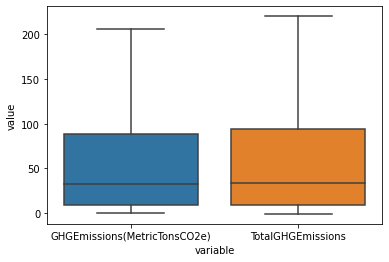

In [80]:
concat_data_1 =pd.concat([df_2015['GHGEmissions(MetricTonsCO2e)'], df_2016['TotalGHGEmissions']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_1), showfliers=False)

In [81]:
#seems the same

<AxesSubplot:xlabel='variable', ylabel='value'>

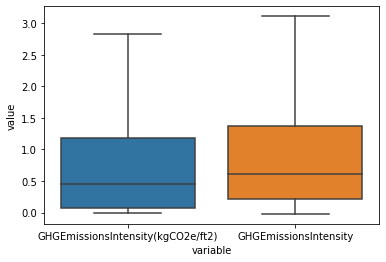

In [82]:
concat_data_2 =pd.concat([df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'], df_2016['GHGEmissionsIntensity']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_2), showfliers=False)

In [83]:
#seems the same

In [84]:
df_2015['OtherFuelUse(kBtu)'].value_counts()

0.0          3313
6464408.0       1
178094.0        1
143134.0        1
5596.0          1
229942.0        1
145944.0        1
427938.0        1
1943011.0       1
12551.0         1
547.0           1
15527.0         1
2304567.0       1
2944419.0       1
337952.0        1
8269669.0       1
177849.0        1
182715.0        1
Name: OtherFuelUse(kBtu), dtype: int64

__Todo :__\
__2015__ 
 - Location : extract data [latitude and longitude, adress, ...]
 - comment/comments ->rename
 - GHGEmissions(MetricTonsCO2e) <->TotalGHGEmissions au vue de la data -> rename
 - 'GHGEmissionsIntensity(kgCO2e/ft2)' <-> 'GHGEmissionsIntensity' -> rename
 - OtherFuelUse(kBtu) : peu d'info -> drop
 - Seattle Police Department Micro Community Policing Plan Areas -> semble non relié à notre probleme -> drop
 - City Council Districts : idem -> drop
 - SPD Beats : semble être des problématique police -> drop
 - Zip Codes : je sais ap ce que c'est -> drop


## Data engeeniring for concat

### deal with Location column

In [85]:
# eval - > permet d'eviter d'avoir un format pourri
df_2015['Location'] = [eval(str(item)) for index, item in df_2015.Location.iteritems()]

In [86]:
df_2015['Latitude'] = df_2015['Location'].apply(lambda x : x['latitude'])
df_2015['Longitude'] = df_2015['Location'].apply(lambda x : x['longitude'])
df_2015['City'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['city'])
df_2015['State'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['state'])
df_2015['ZipCode'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['zip'])

### Deal with renaming + drop

In [87]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions',
                       'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',
                       'Comment':'Comments'},
              inplace=True)

In [88]:
df_2015.drop(columns=['OtherFuelUse(kBtu)',
                      'Seattle Police Department Micro Community Policing Plan Areas', 
                      'City Council Districts',
                      'SPD Beats',
                      'Zip Codes',
                      'Location'],
            inplace=True)

### Concat Df 🍾

In [89]:
list(df_2015.columns).sort() == list(df_2016.columns).sort()

True

In [90]:
df = pd.concat([df_2015, df_2016], axis=0)

In [91]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts', 

# Data Explo

__Definitions :__
- __GFA__ = Gross Floor Area : is the total property square footage, as measured between the exterior walls of the building(s)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   BuildingType                     6716 non-null   object 
 3   PrimaryPropertyType              6716 non-null   object 
 4   PropertyName                     6716 non-null   object 
 5   TaxParcelIdentificationNumber    6714 non-null   object 
 6   CouncilDistrictCode              6716 non-null   int64  
 7   Neighborhood                     6716 non-null   object 
 8   YearBuilt                        6716 non-null   int64  
 9   NumberofBuildings                6708 non-null   float64
 10  NumberofFloors                   6708 non-null   float64
 11  PropertyGFATotal                 6716 non-null   int64  
 12  PropertyGFAParking  

In [93]:
cat_columns=[]
numeric_columns=[]
for column in list(df.columns):
    if df[column].dtype=='object' :
        cat_columns.append(column)
    else :
        numeric_columns.append(column)

In [94]:
df.select_dtypes('float').columns

Index(['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', '2010 Census Tracts'],
      dtype='object')

## Numeric columns

### premiere analyse

In [95]:
df[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6716 non-null   int64  
 1   DataYear                         6716 non-null   int64  
 2   CouncilDistrictCode              6716 non-null   int64  
 3   YearBuilt                        6716 non-null   int64  
 4   NumberofBuildings                6708 non-null   float64
 5   NumberofFloors                   6708 non-null   float64
 6   PropertyGFATotal                 6716 non-null   int64  
 7   PropertyGFAParking               6716 non-null   int64  
 8   PropertyGFABuilding(s)           6716 non-null   int64  
 9   LargestPropertyUseTypeGFA        6560 non-null   float64
 10  SecondLargestPropertyUseTypeGFA  3238 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA   1156 non-null   float64
 12  ENERGYSTARScore     

OSEBuildingID


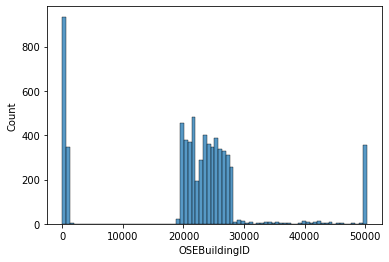

DataYear
2016    3376
2015    3340
Name: DataYear, dtype: int64


CouncilDistrictCode
7    2074
3    1180
2    1016
4     711
5     681
1     562
6     492
Name: CouncilDistrictCode, dtype: int64


YearBuilt


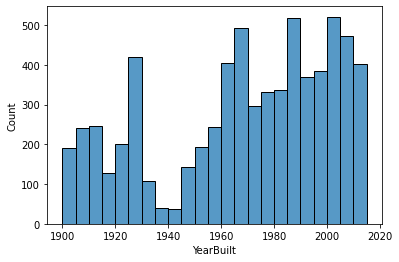

NumberofBuildings


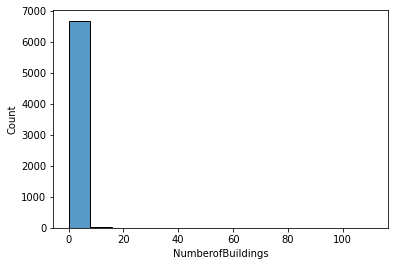

NumberofFloors


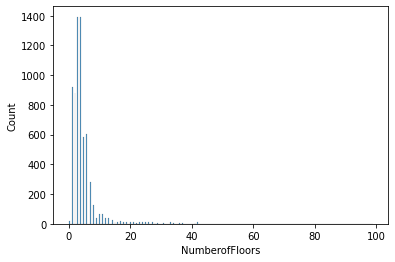

PropertyGFATotal


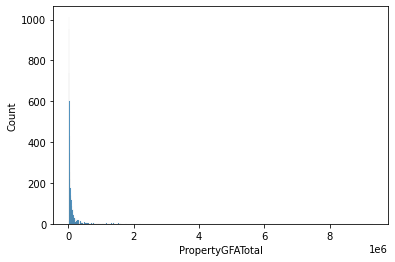

PropertyGFAParking


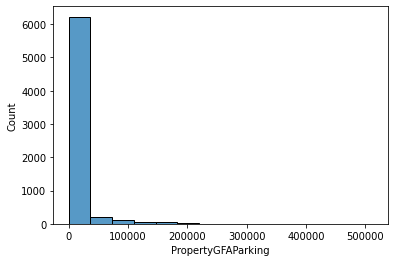

PropertyGFABuilding(s)


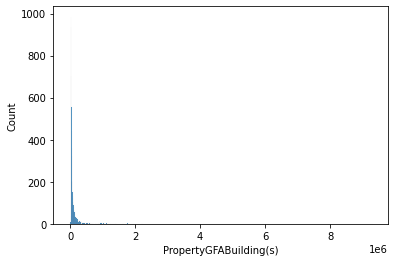

LargestPropertyUseTypeGFA


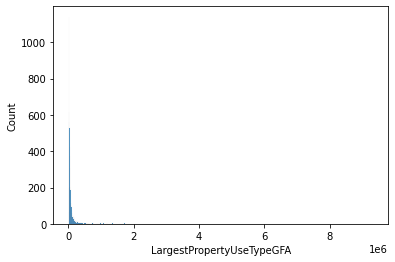

SecondLargestPropertyUseTypeGFA


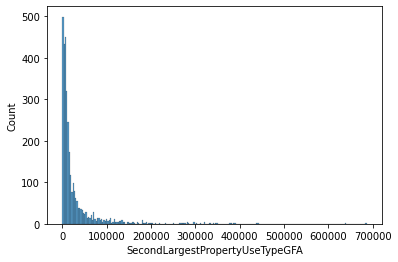

ThirdLargestPropertyUseTypeGFA


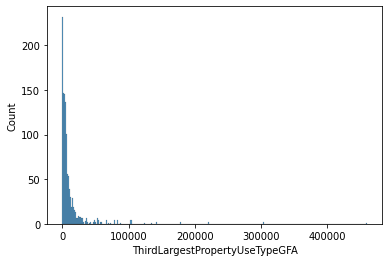

ENERGYSTARScore


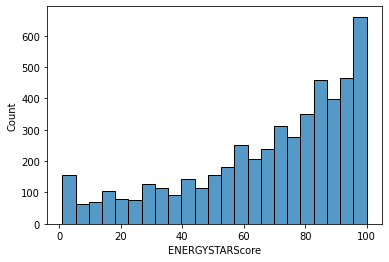

SiteEUI(kBtu/sf)


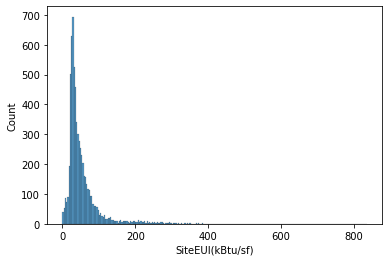

SiteEUIWN(kBtu/sf)


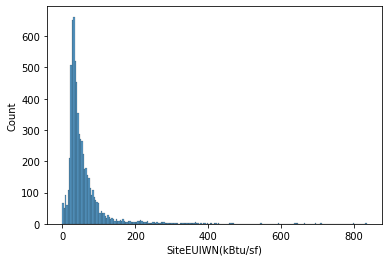

SourceEUI(kBtu/sf)


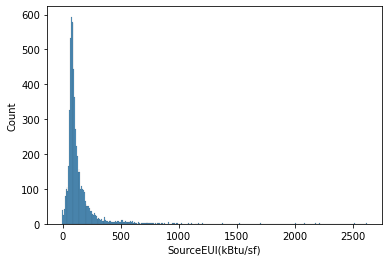

SourceEUIWN(kBtu/sf)


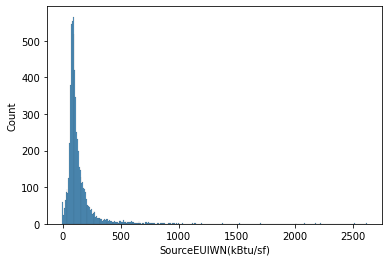

SiteEnergyUse(kBtu)


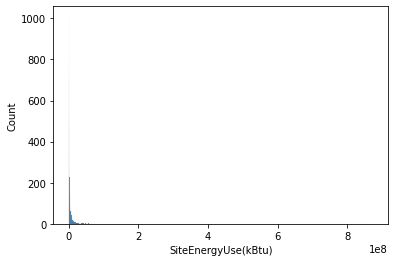

SiteEnergyUseWN(kBtu)


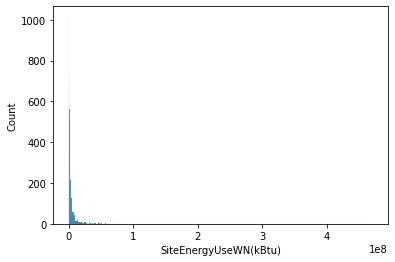

SteamUse(kBtu)


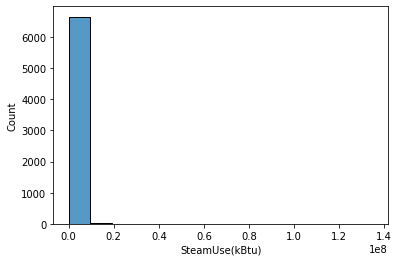

Electricity(kWh)


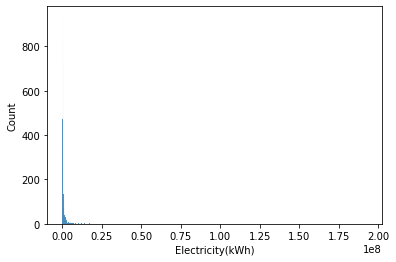

Electricity(kBtu)


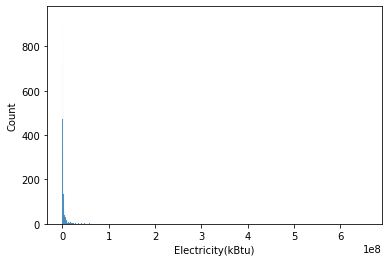

NaturalGas(therms)


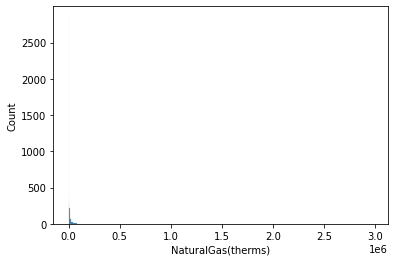

NaturalGas(kBtu)


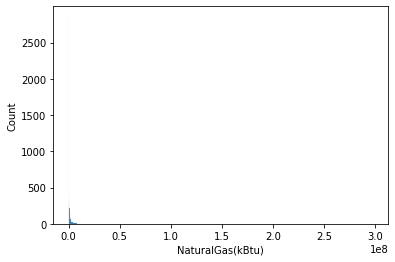

TotalGHGEmissions


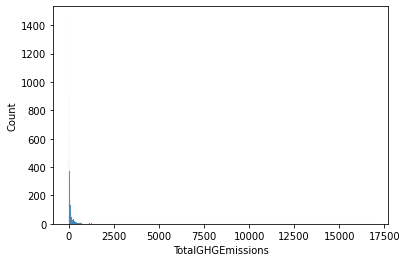

GHGEmissionsIntensity


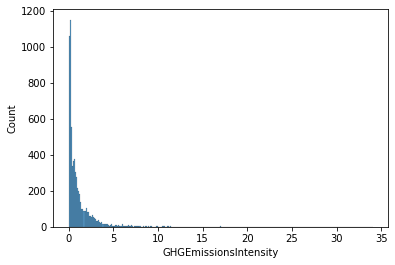

2010 Census Tracts


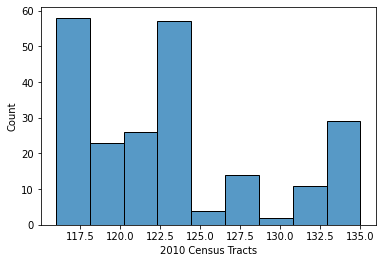

In [96]:
for column in numeric_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print('\n')
    else :
        print(column)
        sns.histplot(df[column])
        plt.show()

In [97]:
numeric_columns

['OSEBuildingID',
 'DataYear',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 '2010 Census Tracts']

<AxesSubplot:>

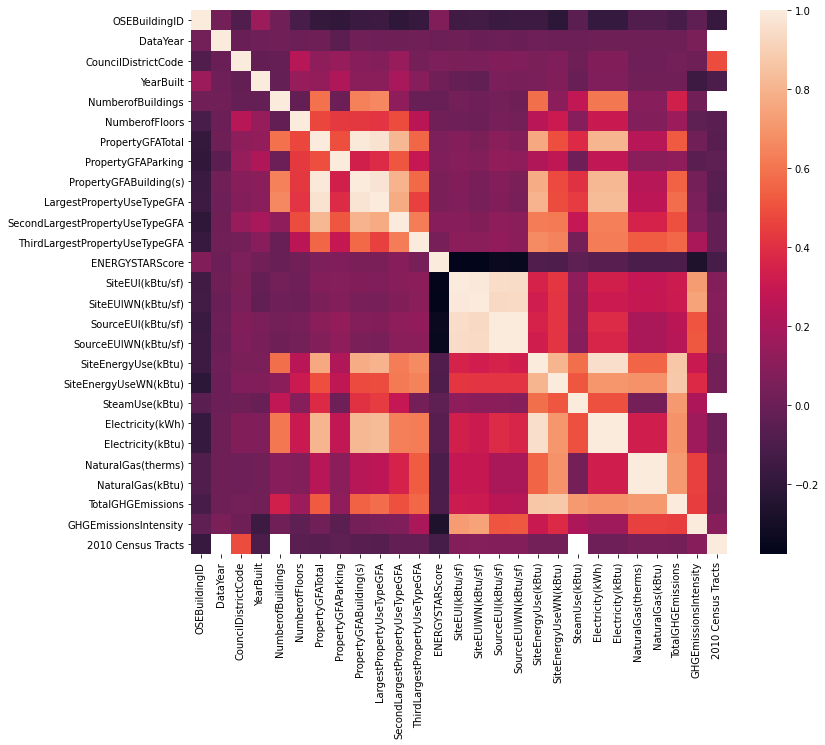

In [101]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr())

In [100]:
corr = df.corr()
corr.style.background_gradient(cmap='Greens').set_precision(3)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_27165/2921387194.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='Greens').set_precision(3)


colonne contenant WN:
- "Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot." -> semble peut pertinant à premiere vue 


In [24]:
numeric_to_drop=[
    'SiteEnergyUseWN(kBtu)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)', #je garde en kwh
    'NaturalGas(therms)',
    '2010 Census Tracts',#trop d'outliers
    'LargestPropertyUseTypeGFA',# a voir
    'SecondLargestPropertyUseTypeGFA',#a voir
    'ThirdLargestPropertyUseTypeGFA',#a voir
    'SiteEUI(kBtu/sf)', # pour la problématique je suprime ces données dépendantes de la surface
    'SourceEUI(kBtu/sf)',# pour la problématique je suprime ces données dépendantes de la surface
    'GHGEmissionsIntensity',# pour la problématique je suprime ces données dépendantes de la surface
    'SteamUse(kBtu)', #à éviter car provient de relevé
    'Electricity(kBtu)', #à éviter car provient de relevé
    'NaturalGas(kBtu)', #à éviter car provient de relevé
    'PropertyGFATotal' #du à la corrélation avec PropertyGFPrking /Building(s)
    ]

In [25]:
df.drop(columns=numeric_to_drop, inplace=True)

In [26]:
numeric_columns = [i for i in numeric_columns if i not in numeric_to_drop]

### Check outliers

In [27]:
df[numeric_columns].describe()

OSEBuildingID    DataYear  CouncilDistrictCode    YearBuilt  \
count    6716.000000  6716.00000          6716.000000  6716.000000   
mean    20867.420488  2015.50268             4.445057  1968.101549   
std     11878.968174     0.50003             2.123749    33.020391   
min         1.000000  2015.00000             1.000000  1900.000000   
25%     19934.000000  2015.00000             3.000000  1948.000000   
50%     23064.000000  2016.00000             4.000000  1974.000000   
75%     25868.250000  2016.00000             7.000000  1996.000000   
max     50226.000000  2016.00000             7.000000  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFAParking  \
count        6708.000000     6708.000000         6716.000000   
mean            1.071407        4.695736         9519.597975   
std             1.593505        5.476218        33868.050881   
min             0.000000        0.000000           -3.000000   
25%             1.000000        2.000000            0.000000   
50%             1.000000        4.000000            0.000000   
75%             1.000000        5.000000            0.000000   
max           111.000000       99.000000       512608.000000   

       PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
count            6.716000e+03      5093.000000         6.701000e+03   
mean             8.329450e+04        67.906342         5.194673e+06   
std              1.733470e+05        27.012124         1.813648e+07   
min             -5.055000e+04         1.000000         0.000000e+00   
25%              2.727300e+04        52.000000         9.200689e+05   
50%              4.218500e+04        75.000000         1.791071e+06   
75%              8.112000e+04        90.000000         4.135280e+06   
max              9.320156e+06       100.000000         8.739237e+08   

       TotalGHGEmissions  
count        6697.000000  
mean          114.935638  
std           478.876573  
min            -0.800000  
25%             9.450000  
50%            33.180000  
75%            91.530000  
max         16870.980000

__Pour remplir les données manquantes des étages/nombres de batiments :__
- remplir par la vaeur associé à l'id du batiment de l'autre année
- par défaut : par 0
- puis remplacer 0 par 1.. *-> à voir implémentation méthode par la moyenne des batiements de la même catégorie ?*

In [28]:
#NumberofBuildings
df['NumberofBuildings'] = df['NumberofBuildings'].fillna(df.groupby('OSEBuildingID')['NumberofBuildings'].transform('max'))
df['NumberofBuildings']=df['NumberofBuildings'].fillna(0)
df['NumberofBuildings'] = df['NumberofBuildings'].replace(0.0, 1.0)
df['NumberofBuildings'].unique()

array([  1.,   7.,  11.,  16.,   4.,   3.,  39.,   2.,  10.,   6.,  27.,
        14.,   9.,   5.,   8.,  23., 111.])

In [29]:
#NumberofFloors cant be 0 floors + deal with outliers
df['NumberofFloors'] = df['NumberofFloors'].fillna(df.groupby('OSEBuildingID')['NumberofFloors'].transform('max'))
df['NumberofFloors'] = df['NumberofFloors'].replace(0.0, 1.0)

In [30]:
df['NumberofFloors'].value_counts()

3.0     1393
4.0     1392
1.0      945
2.0      884
6.0      605
5.0      584
7.0      281
8.0      124
11.0      64
10.0      63
13.0      41
12.0      39
9.0       36
14.0      25
17.0      18
15.0      15
16.0      14
18.0      14
24.0      14
23.0      13
19.0      12
26.0      12
42.0      12
33.0      12
27.0      10
25.0      10
21.0      10
20.0       9
22.0       8
29.0       6
41.0       5
31.0       4
34.0       4
37.0       4
36.0       4
28.0       4
38.0       2
39.0       2
32.0       2
99.0       2
76.0       2
55.0       2
56.0       2
30.0       2
46.0       2
63.0       2
49.0       2
47.0       2
40.0       2
Name: NumberofFloors, dtype: int64

In [31]:
#PropertyGFAParking
df['PropertyGFAParking']=df['PropertyGFAParking'].replace(-3.0, 0.0)

In [32]:
# PropertyGFABuilding(s)
property_gfa_building_neg = list(df[(df['PropertyGFABuilding(s)']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']<0)]['PropertyGFABuilding(s)'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']>0)]['PropertyGFABuilding(s)'].item()
    df['PropertyGFABuilding(s)']=df['PropertyGFABuilding(s)'].replace(to_replace, value)

In [33]:
df['PropertyGFABuilding(s)'].min()

3636

## Cat Columns

In [34]:
for column in cat_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print(f"{len(df[df[column].isna()])} valeurs manquantes'")
        print('\n')
    else :
        print(f'la colonne {column} contient {len(df[column].value_counts())} valeurs différentes et {len(df[df[column].isna()])} valeurs manquantes')
        print('\n')
    

BuildingType
NonResidential          2921
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Nonresidential COS       153
Campus                    46
Nonresidential WA          1
Name: BuildingType, dtype: int64
0 valeurs manquantes'


la colonne PrimaryPropertyType contient 32 valeurs différentes et 0 valeurs manquantes


la colonne PropertyName contient 6527 valeurs différentes et 0 valeurs manquantes


la colonne TaxParcelIdentificationNumber contient 3729 valeurs différentes et 2 valeurs manquantes


la colonne Neighborhood contient 19 valeurs différentes et 0 valeurs manquantes


la colonne ListOfAllPropertyUseTypes contient 488 valeurs différentes et 136 valeurs manquantes


la colonne LargestPropertyUseType contient 57 valeurs différentes et 156 valeurs manquantes


la colonne SecondLargestPropertyUseType contient 50 valeurs différentes et 3478 valeurs manquantes


la colonne ThirdLargestPropertyUseType contient 4

In [35]:
#BuildingType
df['BuildingType']=df['BuildingType'].replace('Nonresidential COS', 'NonResidential')
df['BuildingType']=df['BuildingType'].replace('Nonresidential WA', 'NonResidential')
df['BuildingType'].value_counts()

NonResidential          3075
Multifamily LR (1-4)    2047
Multifamily MR (5-9)    1134
Multifamily HR (10+)     217
SPS-District K-12        197
Campus                    46
Name: BuildingType, dtype: int64

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

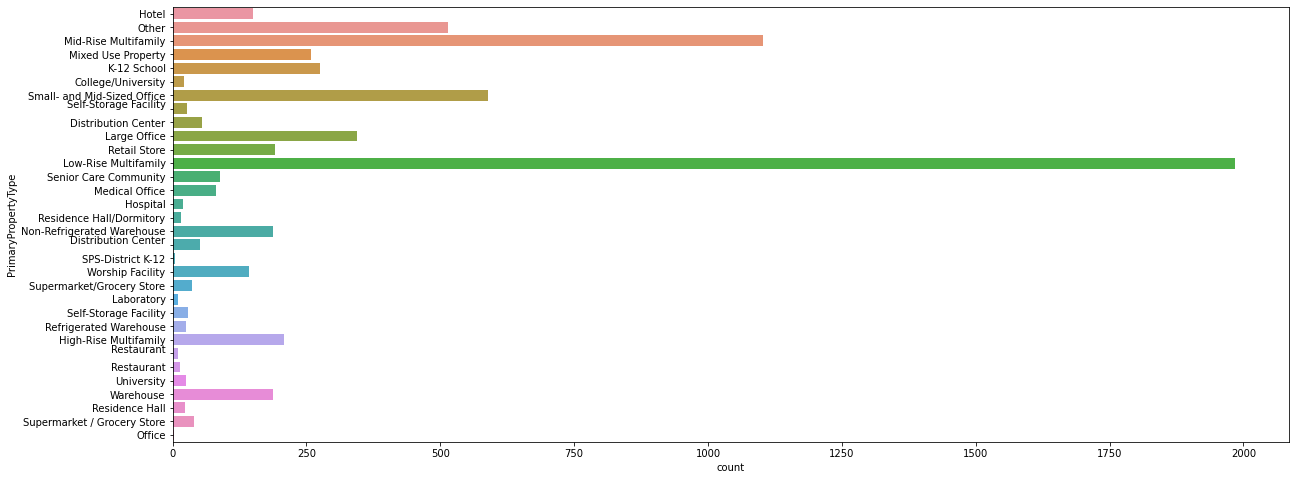

In [36]:
#PrimaryPropertyType
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [37]:
test = df[['PrimaryPropertyType', 'OSEBuildingID']]
dfg=test.groupby(['OSEBuildingID']).agg(set).reset_index()
dfg['taille'] = dfg['PrimaryPropertyType'].apply(lambda x : len(x))
list(dfg[dfg['taille']>1]['PrimaryPropertyType'])

[{'College/University', 'University'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Distribution Center', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Other', 'Retail Store'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'College/University', 'University'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Distribution Center', 'Distribution Center\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'K-12 School', 'SPS-District K-12'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Mixed Use Property', 'Other'},
 {'Non-Refrigerated 

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

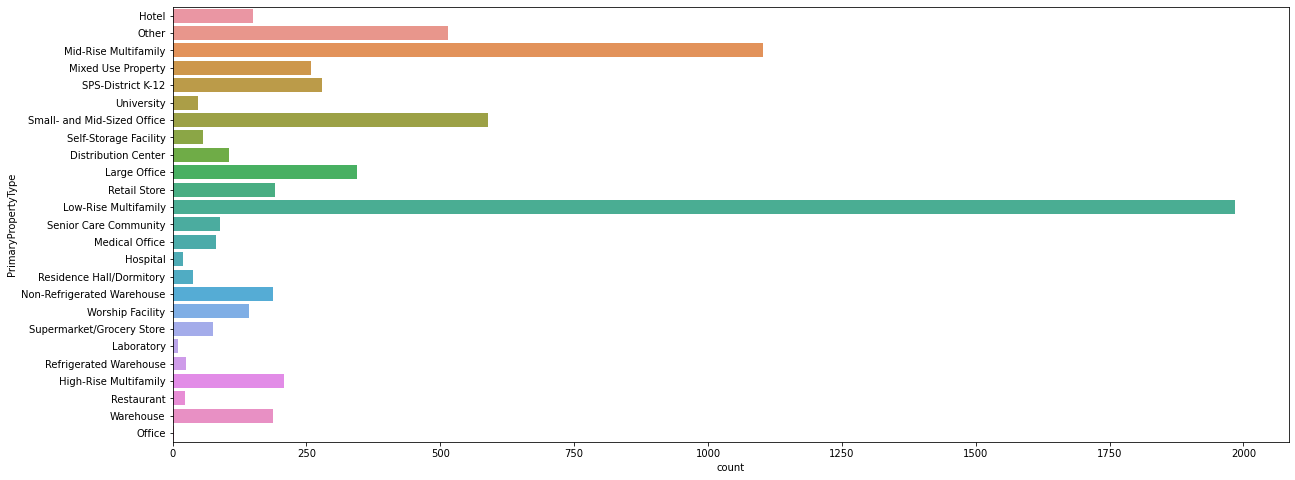

In [38]:
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('College/University', 'University')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility\n', 'Self-Storage Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Distribution Center\n', 'Distribution Center')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Residence Hall', 'Residence Hall/Dormitory')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('K-12 School', 'SPS-District K-12')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Supermarket / Grocery Store', \
                                                            'Supermarket/Grocery Store')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Restaurant\n', 'Restaurant')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [39]:
df_test = df[~(df['PrimaryPropertyType']=='Low-Rise Multifamily')&~(df['PrimaryPropertyType']=='Mid-Rise Multifamily')]
df_test = df_test[df_test['SiteEnergyUse(kBtu)']<50000000]
df_test=df_test.sort_values(by='PrimaryPropertyType')

<AxesSubplot:ylabel='SiteEnergyUse(kBtu)'>

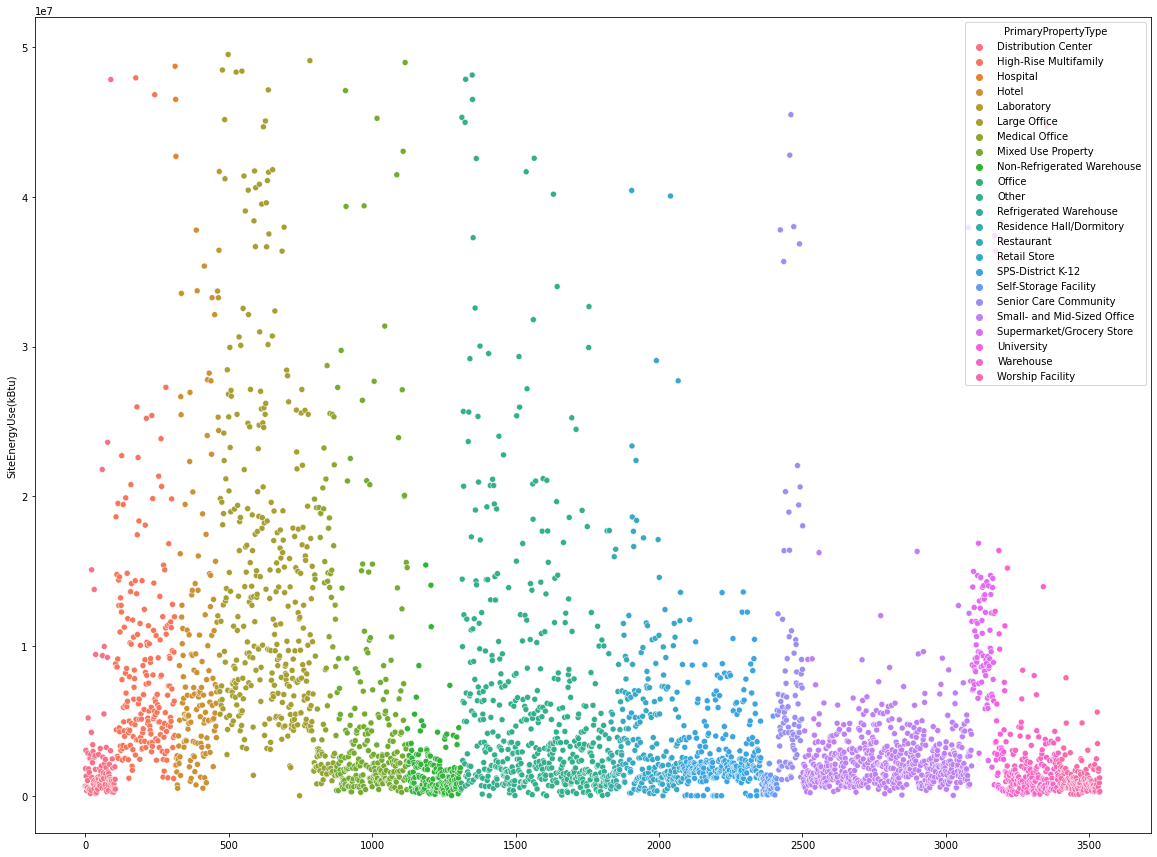

In [40]:
plt.figure(figsize=(20,15))
sns.scatterplot(y=df_test['SiteEnergyUse(kBtu)'], x=[i for i in range(len(df_test))], hue=df_test['PrimaryPropertyType'])


In [41]:
df[['PrimaryPropertyType', 'SiteEnergyUse(kBtu)']].groupby('PrimaryPropertyType').mean()

SiteEnergyUse(kBtu)
PrimaryPropertyType                             
Distribution Center                 2.801173e+06
High-Rise Multifamily               8.853671e+06
Hospital                            1.360147e+08
Hotel                               1.259181e+07
Laboratory                          2.620197e+07
Large Office                        1.748065e+07
Low-Rise Multifamily                1.329059e+06
Medical Office                      1.188233e+07
Mid-Rise Multifamily                2.777192e+06
Mixed Use Property                  9.086191e+06
Non-Refrigerated Warehouse          1.726504e+06
Office                              5.800745e+05
Other                               9.771510e+06
Refrigerated Warehouse              3.522608e+06
Residence Hall/Dormitory            3.448770e+06
Restaurant                          5.181074e+06
Retail Store                        4.864268e+06
SPS-District K-12                   2.905481e+06
Self-Storage Facility               9.125161e+05
Senior Care Community               8.834183e+06
Small- and Mid-Sized Office         2.603963e+06
Supermarket/Grocery Store           9.983782e+06
University                          3.585670e+07
Warehouse                           1.961577e+06
Worship Facility                    1.171687e+06

In [42]:
#Neighborhood
df['Neighborhood']=df['Neighborhood'].str.upper()
df['Neighborhood']=df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print(df['Neighborhood'].value_counts())

DOWNTOWN                 1151
EAST                      897
MAGNOLIA / QUEEN ANNE     843
GREATER DUWAMISH          744
NORTHEAST                 539
LAKE UNION                500
NORTHWEST                 447
NORTH                     375
SOUTHWEST                 331
CENTRAL                   265
BALLARD                   263
SOUTHEAST                 191
DELRIDGE                  170
Name: Neighborhood, dtype: int64


In [103]:
#ListOfAllPropertyUseTypes
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

In [102]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [45]:
#latitude-longitude
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')

In [46]:
to_drop=[
    'TaxParcelIdentificationNumber', #pas d'interet
    'PropertyName', # pas d'interet
    'ListOfAllPropertyUseTypes', # pas d'interet
    'LargestPropertyUseType',# a voir mais beaucoup de taf
    'SecondLargestPropertyUseType',# a voir mais beaucoup de taf
    'ThirdLargestPropertyUseType',# a voir mais beaucoup de taf + nan +++
    "YearsENERGYSTARCertified", #trop de nan + pas d'interet
    'DefaultData',
    'ComplianceStatus',
    'City',
    'State',
    'Address',
    'ZipCode',
    'Comments',
    'Outlier'
]

In [47]:
df=df.drop(columns=to_drop)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           6716 non-null   int64  
 1   DataYear                6716 non-null   int64  
 2   BuildingType            6716 non-null   object 
 3   PrimaryPropertyType     6716 non-null   object 
 4   CouncilDistrictCode     6716 non-null   int64  
 5   Neighborhood            6716 non-null   object 
 6   YearBuilt               6716 non-null   int64  
 7   NumberofBuildings       6716 non-null   float64
 8   NumberofFloors          6716 non-null   float64
 9   PropertyGFAParking      6716 non-null   int64  
 10  PropertyGFABuilding(s)  6716 non-null   int64  
 11  ENERGYSTARScore         5093 non-null   float64
 12  SiteEnergyUse(kBtu)     6701 non-null   float64
 13  TotalGHGEmissions       6697 non-null   float64
 14  Latitude                6716 non-null   

## Nan values energystarscore

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='PrimaryPropertyType'>

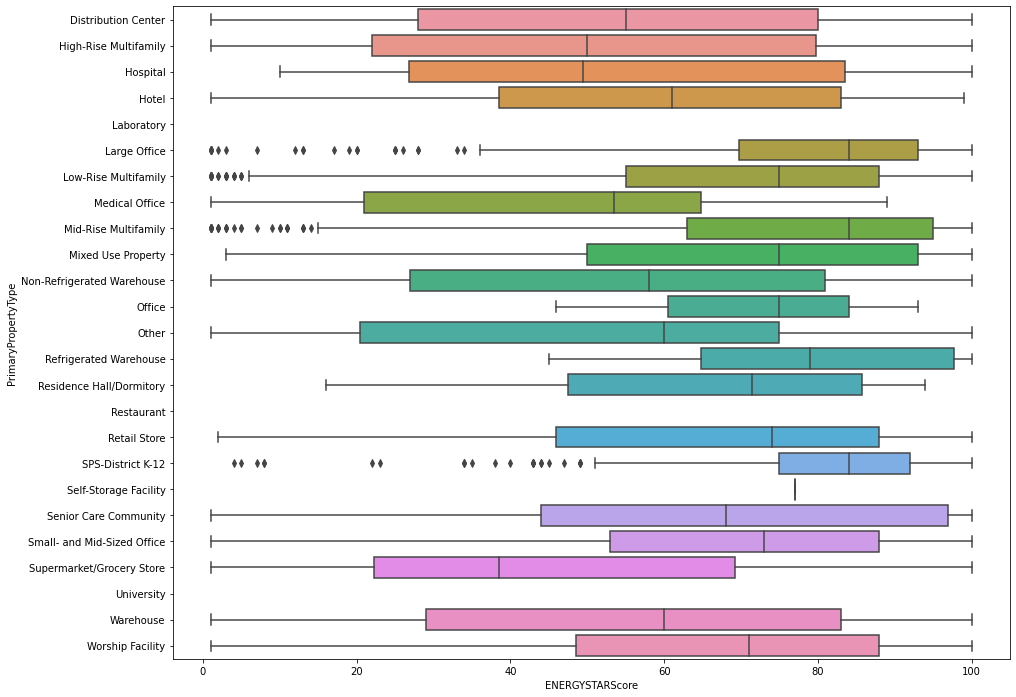

In [49]:
plt.figure(figsize=(15,12))
azerty = df[['ENERGYSTARScore', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='ENERGYSTARScore', data=azerty, orient='h')

In [50]:
df['BuildingAge']=df['DataYear']-df['YearBuilt']
df.drop(columns=['YearBuilt'],inplace=True)

<AxesSubplot:>

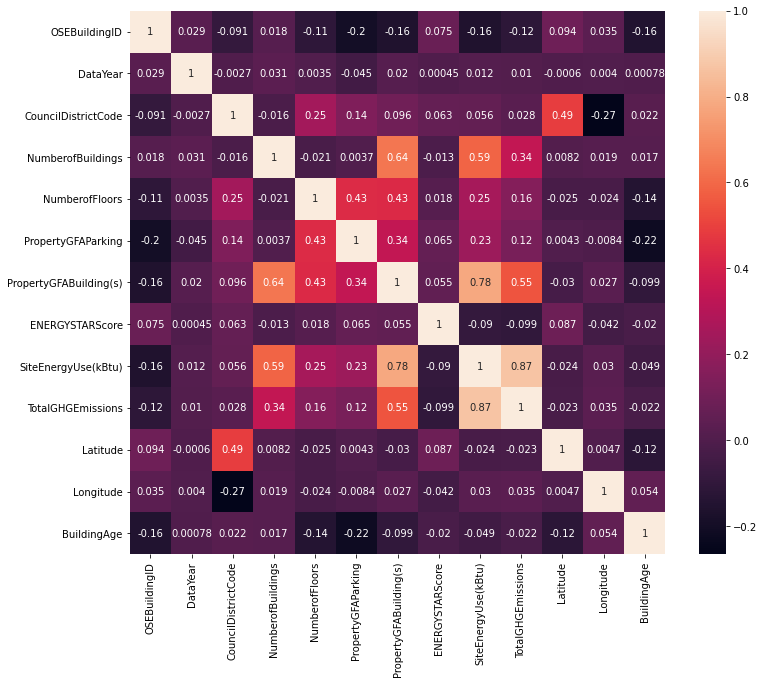

In [51]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

In [52]:
locationlist=[]
for index, row in df.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])

In [53]:
map = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start=12)
for point in range(0, len(df)):
    folium.CircleMarker(locationlist[point],radius=5).add_to(map)
map

In [55]:
'''from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X'''

'from sklearn.feature_selection import SelectFromModel\nselect = SelectFromModel(rfc, prefit=True, threshold=0.003)\nX_train2 = select.transform(X'